## Notebook image tiling

#### Library importation
 - We will need numpy for the mathematical operations on images.
 - Matplotlib will let us display images.
 - TiffFile is used to load the .tif extension files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

#### File Loading
We will just need to triple the image in order to get a 3 channels image for certain operations made for RBG images.

In [4]:
img=tiff.imread("pipix.tif")
img=np.expand_dims(img,-1)
img=np.concatenate((img,img,img),axis=2)

#### Defining the tiling class
This tiling procedure was made to have a reflected image on the sides instead of simple zeros, trouble encountered with the tf.tile method from tensorflow.

In [5]:
class Tile:
    '''
    Usage    : Tile(image,tilesize,overlap,verbose)
    image    : Array of shape [length,width,canals]
    tilesize : The output will be of shape [tilesize,tilesize,canals]
    overlap  : Amount of pixel common between two consecutive tiles
    ================================================================
    Methods  :
    padding(mode="reflect"): Returns a padded image via numpy.pad usage
    tilegeneration()       : Returns a list parts of original image(tiles)
    tilevis(concat=True)   : Plots the tiles list for the image
    detmask()              : Returns the mask of overlapping areas
    reconstruct()          : Builds the image back out of the tile list   
    '''
    
    def __init__(self, image, tilesize=None,overlap=None,verbose=False):
        
        self.im = image
        self.s  = np.shape(self.im)[:2]
        if tilesize is None:tilesize=self.s[0]//4
        self.t  = tilesize
        if overlap is None :overlap =tilesize//4
        self.o  = overlap
        self.verbose=verbose
        self.verdata()
        self.to = self.t-self.o
        self.nbt= [(self.s[0]-self.o)//self.to+1,(self.s[1]-self.o)//self.to+1]
        self.p  = None
        self.pIm= None
        self.tl = None
        
    def verdata(self):
        if (np.shape(self.im)[0]%2)!=0:
            if self.verbose:print("Changing image to an even dimension value, one pixel was removed on axis zero.")
            self.im=self.im[:-1]
        if (np.shape(self.im)[1]%2)!=0:
            if self.verbose:print("Changing image to an even dimension value, one pixel was removed on axis one.")
            self.im=self.im[:,:-1]
        if self.o%2!=0:
            if self.verbose:print("Please use even value for overlap, overlap was reduced by one.")
            self.o-=1
        if self.t>np.shape(self.im)[0] or self.t>np.shape(self.im)[1]:
            if self.verbose:print("You probably didn't do what you want, you will just have one padded image. (Tile size larger than image)")
                      
    def detpad(self):
        psize=[(self.nbt[0]*self.to+self.o)-self.s[0],(self.nbt[1]*self.to+self.o)-self.s[1]]
        for i in range(len(psize)):
            if  psize[i]==self.to:
                psize[i]%=self.to
                self.nbt[i]-=1
        return psize
    
    def padding(self,mode="reflect"):
        if self.p is None:
            self.p=self.detpad()
        padval=int(self.p[0]/2),int(self.p[1]/2)
        pIm=np.pad(self.im,((padval[0],padval[0]),(padval[1],padval[1]),(0,0)),mode=mode)
        return pIm
    
    def tilegeneration(self):
        if self.pIm is None:
            self.pIm=self.padding()
        tiles=[]
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                tiles.append(self.pIm[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t])
        return tiles
    
    def tilevis(self,concat=True):
        if self.tl is None:
            self.tl=self.tilegeneration()
        plt.figure(figsize =( 3*self.nbt[1], 3*self.nbt[0]))
        if not concat:
            for i in range(self.nbt[0]):
                for j in range(self.nbt[1]):
                    ax = plt.subplot(self.nbt[0], self.nbt[1], i*self.nbt[1]+j+1)
                    ax.axis("off")
                    plt.imshow(self.tl[i*self.nbt[1]+j])
        else:
            im=[]
            for i in range(self.nbt[0]):
                line=[]
                for j in range(self.nbt[1]):
                    if j==0: line=self.tl[i*self.nbt[1]+j]
                    else: line = np.concatenate((line,self.tl[i*self.nbt[1]+j]),axis=1)
                if i==0:im=line
                else:im=np.concatenate((im,line),axis=0)
            plt.imshow(im)
        plt.show()
        
    
    def detmask(self):
        if self.pIm is None:
            self.pIm=self.padding()
        mask=np.zeros(np.shape(self.pIm)[:2])
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                mask[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t]+=np.ones((self.t,self.t))
        return mask[int(self.p[0]/2):self.s[0]+int(self.p[0]/2),int(self.p[1]/2):self.s[1]+int(self.p[1]/2)]
    
    def reconstruct(self):
        if self.tl is None:
            self.tl=self.tilegeneration()
        reim=np.zeros(np.shape(self.pIm))
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                reim[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t]+=self.tl[i*self.nbt[1]+j]
        reim=reim[int(self.p[0]/2):self.s[0]+int(self.p[0]/2),int(self.p[1]/2):self.s[1]+int(self.p[1]/2)]
        mask=self.detmask()
        for i in range(np.shape(reim)[2]):
            reim[...,i]/=mask
        return reim.astype(int)
    
allo=Tile(img)
print(allo.__doc__)


    Usage    : Tile(image,tilesize,overlap,verbose)
    image    : Array of shape [length,width,canals]
    tilesize : The output will be of shape [tilesize,tilesize,canals]
    overlap  : Amount of pixel common between two consecutive tiles
    Methods  :
    padding(mode="reflect"): Returns a padded image via numpy.pad usage
    tilegeneration()       : Returns a list parts of original image(tiles)
    tilevis(concat=True)   : Plots the tiles list for the image
    detmask()              : Returns the mask of overlapping areas
    reconstruct()          : Builds the image back out of the tile list   
    


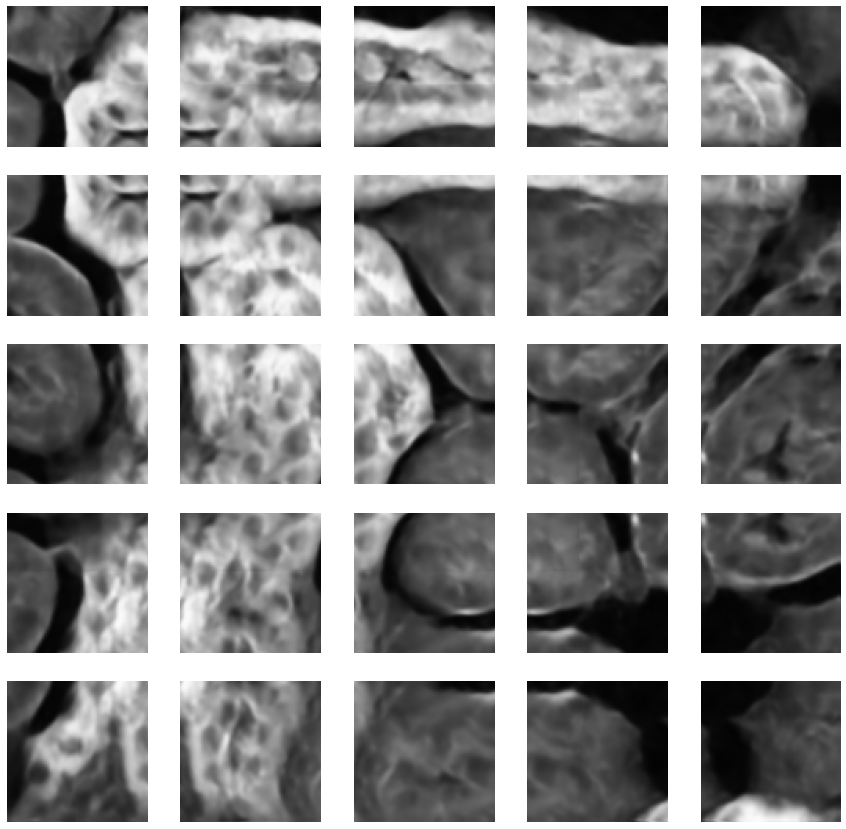

In [6]:
allo.tilevis(concat=False)